### libraries used in teh experiment

In [1]:
from __future__ import division
import os
import sys
import argparse
import glob

import torch
import logging
import torch.nn as nn
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import math
import time
import copy
import seaborn as sns

import imageio
from IPython.display import display, HTML 
import trimesh
# trimesh.util.attach_to_log(logging.DEBUG,me)

import neural_renderer as nr

current_dir = os.getcwd()
data_dir = current_dir


### supporting functions

In [2]:
def make_gif(filename):
    with imageio.get_writer(filename, mode='I') as writer:
        for filename in sorted(glob.glob('/tmp/_tmp_*.png')):
            writer.append_data(imread(filename))
            os.remove(filename)
    writer.close()
def load_mymesh(data_dir,anchor,object_list):
    filename_obj =  os.path.join(data_dir,"{}.obj".format(object_list[anchor]))
    vertices, faces = nr.load_obj(filename_obj)
    vertices = vertices[None, :, :]  # [num_vertices, XYZ] -> [batch_size=1, num_vertices, XYZ]
    faces = faces[None, :, :]  # [num_faces, 3] -> [batch_size=1, num_faces, 3]
    return vertices ,faces

### defining the models 

In [10]:
class renderer_model(nn.Module):
    def __init__(self, network_model,vertices,faces,camera_distance,elevation,azimuth,image_size):
        super(renderer_model, self).__init__()
        self.register_buffer('vertices', vertices)
        self.register_buffer('faces', faces)

        # create textures
        texture_size = 2
        textures = torch.ones(self.faces.shape[0], self.faces.shape[1], texture_size, texture_size, texture_size, 3, dtype=torch.float32)
        self.register_buffer('textures', textures)

        # define the DNN model as part of the model of the renderer 
        self.network_model =  network_model
        
        self.register_buffer('camera_distance', torch.from_numpy(np.array(camera_distance)).float().unsqueeze_(0))
        self.register_buffer('elevation', torch.from_numpy(np.array(elevation)).float().unsqueeze_(0))
        
        
        # camera parameters
#         self.camera_position = nn.Parameter(torch.from_numpy(np.array([6, 10, -14], dtype=np.float32)))
        self.azimuth = nn.Parameter(torch.from_numpy(np.array(azimuth)).float().unsqueeze_(0))  ### if anthc remove unsqueeze


        # setup renderer
        renderer = nr.Renderer(camera_mode='look_at',image_size=image_size)
#         renderer.eye = self.camera_position
        self.renderer = renderer

    def forward(self,azimuth):
        self.azimuth.data.set_(torch.from_numpy(np.array(azimuth)).float().to(device))
        self.renderer.eye =nr.get_points_from_angles(self.camera_distance, self.elevation, self.azimuth)
        images = self.renderer(self.vertices, self.faces,self.textures)
        prop = torch.functional.F.softmax(self.network_model(images[0]),dim=1)
        return prop

### defining the evaluation functions 

In [11]:
# to gpu
def evaluate_robustness(model,camera_distance,elevation,analysis_domain,data_dir,image_size,anchor,object_list):
    """
    evluate the robustness of the DNN model over the fulll range of domain analysis ias azimujth angles and record a gif of teh rotated object 
    """
    image_collection = []
    prop_profile = []
    class_profile =[]
    filename_obj =  os.path.join(data_dir,"{}.obj".format(object_list[anchor]))
    filename_ref = os.path.join(data_dir,"{}_ref.png".format(object_list[anchor]))
    file_out = os.path.join(data_dir,"{}_out.gif".format(object_list[anchor]))
    file_opt = os.path.join(data_dir,"{}_opt.gif".format(object_list[anchor]))
    obj_class = obj_class_list[anchor] # imageNet label 
    texture_size = 2
    
    # load .obj
    vertices, faces = nr.load_obj(filename_obj)
    vertices = vertices[None, :, :]  # [num_vertices, XYZ] -> [batch_size=1, num_vertices, XYZ]
    faces = faces[None, :, :]  # [num_faces, 3] -> [batch_size=1, num_faces, 3]

    # create texture [batch_size=1, num_faces, texture_size, texture_size, texture_size, RGB]
    textures = torch.ones(1, faces.shape[1], texture_size, texture_size, texture_size, 3, dtype=torch.float32).to(device)
    
    # create renderer
    renderer = nr.Renderer(camera_mode='look_at',image_size=image_size)
    
    loop = tqdm(analysis_domain)
    writer = imageio.get_writer(file_out, mode='I')
    writer.append_data(np.ones([image_size,image_size,3]).astype(np.uint8))
    model.eval()
    # draw object
    for num, azimuth in enumerate(loop):
    #     loop.set_description('Drawing')
        renderer.eye = nr.get_points_from_angles(camera_distance, elevation, azimuth)
        images = renderer(vertices, faces, textures,)  # [batch_size, RGB, image_size, image_size]
        with torch.no_grad():
            prop = torch.functional.F.softmax(model(images[0]),dim=1)
            class_profile.append(torch.max(prop,1)[1].detach().cpu().numpy())
            prop_profile.append(prop[0,obj_class].detach().cpu().numpy())
        image = images[0].detach().cpu().numpy()[0].transpose((1, 2, 0))  # [image_size, image_size, RGB]
        writer.append_data((255*image).astype(np.uint8))
        image_collection.append((255*image).astype(np.uint8))
#         imageio.mimsave(os.path.join(data_dir,"%s.gif"%(object_list[anchor])),image_collection)
    writer.close()
    return prop_profile , class_profile


# to gpu

    
    
def query_robustness(renderer,obj_class,querry_point):
    with torch.no_grad():
        prop = renderer(querry_point)
    return prop[0,obj_class].detach().cpu().numpy()
    
    
    
#     texture_size = 2
#     # create texture [batch_size=1, num_faces, texture_size, texture_size, texture_size, RGB]
#     textures = torch.ones(1, faces.shape[1], texture_size, texture_size, texture_size, 3, dtype=torch.float32).to(device)
    
#     # create renderer
#     renderer = nr.Renderer(camera_mode='look_at',image_size=image_size)
#     model.eval()
#     # draw object
# #     loop.set_description('Drawing')
#     renderer.eye = nr.get_points_from_angles(camera_distance, elevation, azimuth)
#     images = renderer(vertices, faces, textures,)  # [batch_size, RGB, image_size, image_size]
#     with torch.no_grad():
#         prop = torch.functional.F.softmax(model(images),dim=1)
#     return prop[0,obj_class].detach().cpu().numpy()

def query_gradient(renderer,obj_class,querry_point):
    prop = renderer(querry_point)
    labels = torch.tensor([obj_class]).to(device)  #torch.from_numpy(np.tile(np.eye(1000)[obj_class],(1,prop.size()[0]))).float().to(device)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(prop,labels)
    renderer.zero_grad()
    loss.backward(retain_graph=True)
    return renderer.azimuth.grad.cpu().numpy()


### visulaizing the probability distribution of softmax and the mesh being analyzed

In [12]:
def visulize_function_profiles(function_profiles,analysis_domain,label_profiles,title,xlabel,ylabel,fit_poly=False,limit_y=True):
    plt.figure(figsize = (8, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for exp in range(len(function_profiles)):
        x = np.array(analysis_domain)
        y= np.array(function_profiles[exp])
        if fit_poly:
            y = np.poly1d(np.array(function_profiles[exp]))
            z = np.polyfit(x, y, 20)
            f = np.poly1d(z)
            x_new = np.linspace(x[0], x[-1], 150)
            y_new = f(x_new)
            plt.plot(x_new,y_new,linewidth=2,alpha=1,label=label_profiles[exp])
        else:
            plt.plot(x,y,linewidth=1,alpha=1,label=label_profiles[exp])
            
    plt.legend()
    plt.xlim(min(analysis_domain),max(analysis_domain)) 
    if limit_y:
        plt.ylim(min(function_profiles[0]),max(function_profiles[0])) 
        
    
def visulize_softmax(prop_profiles,class_profiles,analysis_domain,object_list,fit_poly=False):
    for exp in range(len(object_list)):
        print("class: %s, mean: %1.3f , std: %1.3f" %(object_list[exp],np.mean(np.array(prop_profiles[exp])),np.std(np.array(prop_profiles[exp]))))
        print("most common class label is %d with frequency %2.1f percent " %(int(stats.mode(np.array(class_profiles[exp]))[0]),100*float(stats.mode(np.array(class_profiles[exp]))[1])/len(class_profiles[exp])))

    plt.figure(figsize = (8, 6))
    plt.title("the ResNet softmax probability of an object on different azimuth rotations")
    plt.xlabel("the azimuth rotation around teh object (degrees)")
    plt.ylabel("Rsnet softmax prob of that class")
    for exp in range(len(prop_profiles)):
        # # for ii in range(self.nb_parameters):
        x = np.array(analysis_domain)
        y = np.poly1d(np.array(prop_profiles[exp]))
        z = np.polyfit(x, y, 20)
        f = np.poly1d(z)
        x_new = np.linspace(x[0], x[-1], 150)
        y_new = f(x_new)
        if fit_poly:
            plt.plot(x_new,y_new,linewidth=2,alpha=1,label=object_list[exp])
        else:
#             plt.scatter(x,y,alpha=0.5,s=10,label=object_list[exp])
            plt.plot(x,y,linewidth=1,alpha=1,label=object_list[exp])
            
        # sns.kdeplot(np.array(prop_profile).tolist(), linewidth = 2, shade = False, label=self.paramters_list[ii],clip=(-1,1))
    plt.legend()
    plt.xlim(min(analysis_domain),max(analysis_domain))    
    # plt.savefig(os.path.join(self.generated_frames_test_dir,"parmeters_%d_%d.jpg"%(step,self.evolve_step)))
    # plt.close()
    


def visulize_network(network_dicts,analysis_domain,object_list,object_number=0,fit_poly=False):
    """
    the network_dicts has dixtionary that contain keys of network names and values of prop profiles for these networks on the 
    target analysss domain
    
    """
    plt.figure(figsize = (8, 6))
    plt.title(r"the softmax probability of %s object on different azimuth rotations" %(object_list[object_number].upper()),fontsize=15)
    plt.xlabel("the azimuth rotation around the object (degrees)",fontsize=13)
    plt.ylabel("softmax prob of the %s class" %(object_list[object_number].upper()),fontsize=13)
    for k ,v  in network_dicts.items():
        # # for ii in range(self.nb_parameters):
        x = np.array(analysis_domain)
        y = np.poly1d(np.array(v[object_number]))
        z = np.polyfit(x, y, 20)
        f = np.poly1d(z)
        x_new = np.linspace(x[0], x[-1], 150)
        y_new = f(x_new)
        if fit_poly:
            plt.plot(x_new,y_new,linewidth=2,alpha=1,label=k)
        else:
            plt.plot(x,y,linewidth=1,alpha=1,label=k)
    plt.plot(x,np.ones_like(x),'k--',linewidth=1,alpha=0.8,label="Human")
    plt.legend(fontsize=12)
    plt.xlim(min(analysis_domain),max(analysis_domain))    
    plt.savefig(os.path.join(data_dir,"results","azimuth_performance_%s.pdf"%(object_list[object_number].upper())))


def visulaize_mesh(anchor,object_list,data_dir,view_3d=False):
    filename_obj =  os.path.join(data_dir,"{}.obj".format(object_list[anchor]))
    filename_out =  os.path.join(data_dir,"{}_out.gif".format(object_list[anchor]))
    display(HTML("<img src='{}'></img>".format(filename_out)))
    if view_3d:
        logging.disable(sys.maxsize)
        mesh = trimesh.load(filename_obj)
        return mesh

def visulize_trace(optimization_trace,loss_trace,object_list,object_number=0,exp_type=None):
    """
    visualize the trace taken by the optimization on the two variables (a,b) contained in the list optimization_trace
    
    """
    t = np.array(range(len(optimization_trace)))
    
    fig, ax1 = plt.subplots()
    plt.title("azimuth rotations trace during optimization of %s class in the %s exp" %(object_list[object_number].upper(),str(exp_type).upper()))
    ax1.set_xlabel("iterations (steps)")
    ax1.set_ylabel("zimuth rotations change " )
    aa = np.array([x[0] for x in optimization_trace])
    bb = np.array([x[1] for x in optimization_trace])
    ax1.plot(t,aa,linewidth=1,alpha=1,label="the left bound a")
    ax1.plot(t,bb,linewidth=1,alpha=1,label="the right bound b")
    ax1.tick_params(axis='y')
    plt.legend()
    ax1.set_xlim(0,len(optimization_trace))   
    ax1.set_ylim(np.min(aa),np.max(bb))
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, np.array(loss_trace), color=color)
    ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()  # otherwise the right y-label is slightly clipped

# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
# ax1.plot(t, data1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)



## visualizing the networks on azimuth range

### experimtn setup

In [13]:
object_list = ["teapot","truck","boat","tv"]
obj_class_list = [849,586,606,549]
anchor = 3
camera_distance = 2.732
domain_begin = 0 ; domain_end = 360 ; domain_precision = 2
analysis_domain = range(domain_begin, domain_end, domain_precision)
elevation = 35
image_size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### define the deep model 
resnet = models.resnet50(pretrained=True).eval().to(device)
resnet = nn.DataParallel(resnet)
# print(resnet)
# nr.renderer??

/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [14]:
prop_profiles = [] ; class_profiles = []
for exp in range(len(object_list)):
    prop_profile , class_profile = evaluate_robustness(resnet,camera_distance,elevation,analysis_domain,data_dir,image_size,exp,object_list)
    prop_profiles.append(prop_profile) ; class_profiles.append(class_profile)


100%|██████████| 180/180 [00:09<00:00, 20.46it/s]

100%|██████████| 180/180 [02:56<00:00,  1.01s/it]

100%|██████████| 180/180 [00:57<00:00,  3.03it/s]

100%|██████████| 180/180 [00:23<00:00,  7.83it/s]


class: teapot, mean: 0.488 , std: 0.383
most common class label is 849 with frequency 62.8 percent 
class: truck, mean: 0.222 , std: 0.264
most common class label is 586 with frequency 42.2 percent 
class: boat, mean: 0.180 , std: 0.203
most common class label is 606 with frequency 27.8 percent 
class: tv, mean: 0.525 , std: 0.325
most common class label is 549 with frequency 81.1 percent 


/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned


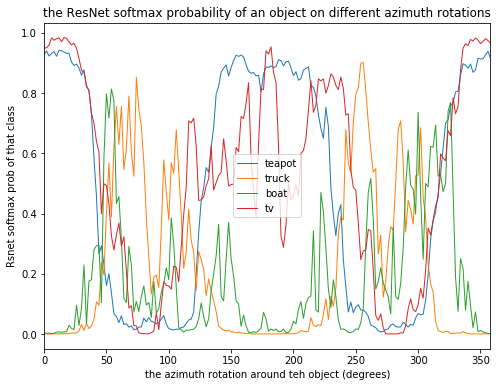

In [16]:
visulize_softmax(prop_profiles,class_profiles,analysis_domain,object_list,fit_poly=False)
# visulize_softmax(prop_profiles,class_profiles,analysis_domain,object_list,fit_poly=True)  

In [20]:
object_list = ["teapot","truck","boat","tv"]
obj_class_list = [849,845,619,549]
anchor = 3
camera_distance = 2.732
domain_begin = 0 ; domain_end = 360 ; domain_precision = 2
analysis_domain = range(domain_begin, domain_end, domain_precision)
elevation = 35
image_size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### define the deep model 
alexnet = models.alexnet(pretrained=True).eval().to(device)
alexnet = nn.DataParallel(alexnet)
# print(resnet)

/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [14]:
Aprop_profiles = [] ; Aclass_profiles = []
for exp in range(len(object_list)):
    prop_profile , class_profile = evaluate_robustness(alexnet,camera_distance,elevation,analysis_domain,data_dir,image_size,exp,object_list)
    Aprop_profiles.append(prop_profile) ; Aclass_profiles.append(class_profile)

100%|██████████| 180/180 [00:02<00:00, 78.53it/s]


class: teapot, mean: 0.001 , std: 0.000
most common class label is 783 with frequency 100.0 percent 
class: truck, mean: 0.008 , std: 0.000
most common class label is 783 with frequency 100.0 percent 
class: boat, mean: 0.005 , std: 0.000
most common class label is 783 with frequency 100.0 percent 
class: tv, mean: 0.001 , std: 0.000
most common class label is 783 with frequency 100.0 percent 
class: teapot, mean: 0.001 , std: 0.000
most common class label is 783 with frequency 100.0 percent 
class: truck, mean: 0.008 , std: 0.000
most common class label is 783 with frequency 100.0 percent 
class: boat, mean: 0.005 , std: 0.000
most common class label is 783 with frequency 100.0 percent 
class: tv, mean: 0.001 , std: 0.000
most common class label is 783 with frequency 100.0 percent 


/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/ipykernel_launcher.py:38: RankWarning: Polyfit may be poorly conditioned
/home/hamdiaj/anaconda3/env

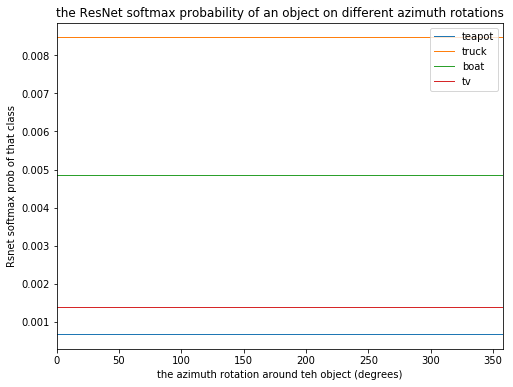

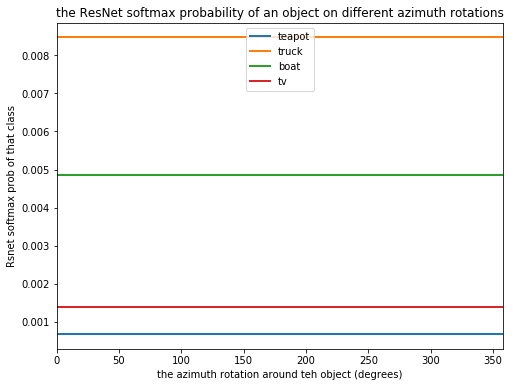

In [15]:
visulize_softmax(Aprop_profiles,Aclass_profiles,analysis_domain,object_list,fit_poly=False)
# visulize_softmax(Aprop_profiles,Aclass_profiles,analysis_domain,object_list,fit_poly=True)  

In [21]:
object_list = ["teapot","truck","boat","tv"]
obj_class_list = [849,845,619,549]
anchor = 3
camera_distance = 2.732
domain_begin = 0 ; domain_end = 360 ; domain_precision = 2
analysis_domain = range(domain_begin, domain_end, domain_precision)
elevation = 35
image_size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### define the deep model 
vgg = models.vgg11_bn(pretrained=True).eval().to(device)
vgg = nn.DataParallel(vgg)
# print(resnet)

/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [20]:
Vprop_profiles = [] ; Vclass_profiles = []
for exp in range(len(object_list)):
    prop_profile , class_profile = evaluate_robustness(vgg,camera_distance,elevation,analysis_domain,data_dir,image_size,exp,object_list)
    Vprop_profiles.append(prop_profile) ; Vclass_profiles.append(class_profile)

100%|██████████| 180/180 [00:22<00:00,  8.17it/s]


/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj

class: teapot, mean: 0.099 , std: 0.104
most common class label is 968 with frequency 45.0 percent 
class: truck, mean: 0.048 , std: 0.056
most common class label is 720 with frequency 21.7 percent 
class: boat, mean: 0.018 , std: 0.018
most common class label is 549 with frequency 37.8 percent 
class: tv, mean: 0.438 , std: 0.280
most common class label is 549 with frequency 81.7 percent 
class: teapot, mean: 0.099 , std: 0.104
most common class label is 968 with frequency 45.0 percent 
class: truck, mean: 0.048 , std: 0.056
most common class label is 720 with frequency 21.7 percent 
class: boat, mean: 0.018 , std: 0.018
most common class label is 549 with frequency 37.8 percent 
class: tv, mean: 0.438 , std: 0.280
most common class label is 549 with frequency 81.7 percent 


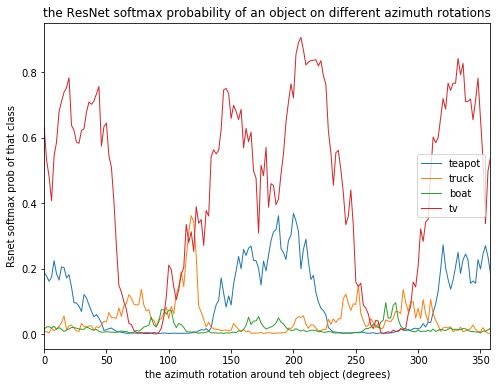

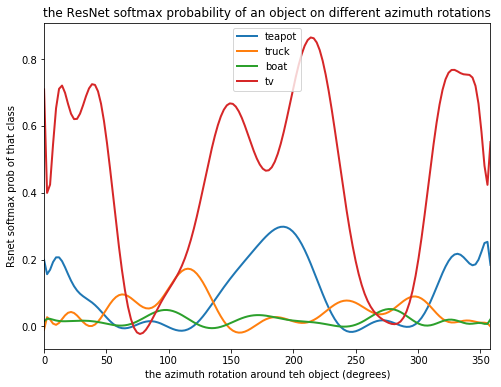

In [21]:
visulize_softmax(Vprop_profiles,Vclass_profiles,analysis_domain,object_list,fit_poly=False)
# visulize_softmax(Vprop_profiles,Vclass_profiles,analysis_domain,object_list,fit_poly=True)  

In [22]:
object_list = ["teapot","truck","boat","tv"]
obj_class_list = [849,586,606,549] 
anchor = 3
camera_distance = 2.732
domain_begin = 0 ; domain_end = 360 ; domain_precision = 2
analysis_domain = range(domain_begin, domain_end, domain_precision)
elevation = 35
image_size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### define the deep model 
incept = models.inception_v3(pretrained=True).eval().to(device)
incept = nn.DataParallel(incept)
# print(resnet)

/home/hamdiaj/anaconda3/envs/semantic/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [23]:
Iprop_profiles = [] ; Iclass_profiles = []
for exp in range(len(object_list)):
    prop_profile , class_profile = evaluate_robustness(incept,camera_distance,elevation,analysis_domain,data_dir,image_size,exp,object_list)
    Iprop_profiles.append(prop_profile) ; Iclass_profiles.append(class_profile)

100%|██████████| 180/180 [00:24<00:00,  7.51it/s]


/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj/anaconda3/envs/mytorch/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/home/hamdiaj

class: teapot, mean: 0.706 , std: 0.448
most common class label is 968 with frequency 45.0 percent 
class: truck, mean: 0.009 , std: 0.021
most common class label is 720 with frequency 21.7 percent 
class: boat, mean: 0.411 , std: 0.461
most common class label is 549 with frequency 37.8 percent 
class: tv, mean: 0.005 , std: 0.011
most common class label is 549 with frequency 81.7 percent 
class: teapot, mean: 0.706 , std: 0.448
most common class label is 968 with frequency 45.0 percent 
class: truck, mean: 0.009 , std: 0.021
most common class label is 720 with frequency 21.7 percent 
class: boat, mean: 0.411 , std: 0.461
most common class label is 549 with frequency 37.8 percent 
class: tv, mean: 0.005 , std: 0.011
most common class label is 549 with frequency 81.7 percent 


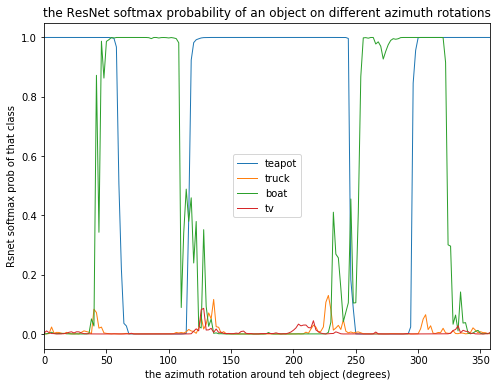

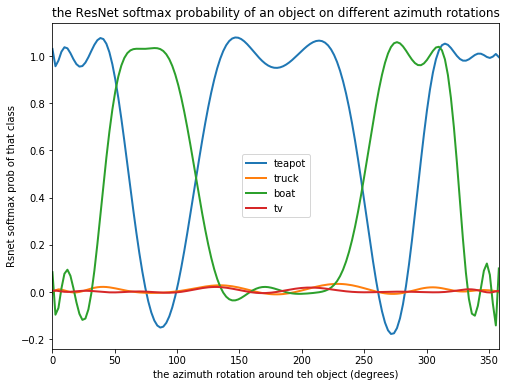

In [24]:
visulize_softmax(Iprop_profiles,Vclass_profiles,analysis_domain,object_list,fit_poly=False)
# visulize_softmax(Iprop_profiles,Vclass_profiles,analysis_domain,object_list,fit_poly=True)  

### visualizing all the networks together 

In [24]:
models_dicts = {"ResNet50":resnet , "AlexNet": alexnet , "VGG":vgg , "Inceptionv3":incept}
network_prop_dicts = {"ResNet50":prop_profiles , "AlexNet": Aprop_profiles , "VGG":Vprop_profiles , "Inceptionv3":Iprop_profiles}

NameError: name 'Aprop_profiles' is not defined

### saving/ loading the models

In [9]:
torch.save(network_prop_dicts,os.path.join(data_dir,'network_profiles.pt'))
network_prop_dicts = torch.load(os.path.join(data_dir,'network_profiles.pt'))

In [23]:
itr = iter(range(len(object_list)))

### Run the block below several times 

In [25]:
current_object = next(itr)
# visulize_network(network_prop_dicts,analysis_domain,object_list,object_number=current_object,fit_poly=False)
mesh = visulaize_mesh(current_object,object_list,data_dir=data_dir,view_3d=True)
mesh.show()
